**Цель проекта:** предсказание температуры стали для оптимизации производственных расходов

**Описание проекта:** чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

# Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

import time
from datetime import datetime

## Иследовательский анализ данных

**Данные об электродах**

In [2]:
df_arc = pd.read_csv('/datasets/data_arc_new.csv');
df_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [3]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


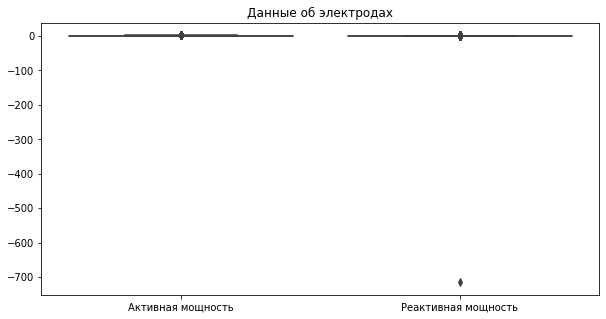

In [4]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_arc.drop(['key'], axis=1))
plt.title('Данные об электродах')
plt.show();

**Промежуточный вывод:** видим одно отрицательное значение, возможно сбой в системе замеряющей мощность.

**Данные о подаче сыпучих материалов(объем)**

In [5]:
df_bulk = pd.read_csv('/datasets/data_bulk_new.csv');
df_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [6]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


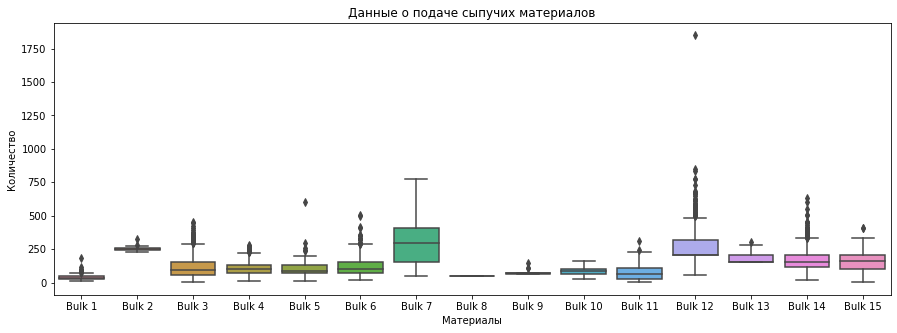

In [7]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_bulk.drop('key', axis=1))
plt.title('Данные о подаче сыпучих материалов')
plt.xlabel('Материалы')
plt.ylabel('Количество')
plt.show();

**Промежуточный вывод:**

    1. Много пропусков
    2. Построили ящик с усами для выявления выбросов

**Данные о подаче сыпучих материалов(время)**

In [8]:
df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv');df_bulk_time.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [9]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


**Промежуточный вывод:**

    1.Есть много пропусков в данных.

**Данные о продувке сплава газом**

In [10]:
df_gas = pd.read_csv('/datasets/data_gas_new.csv');
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


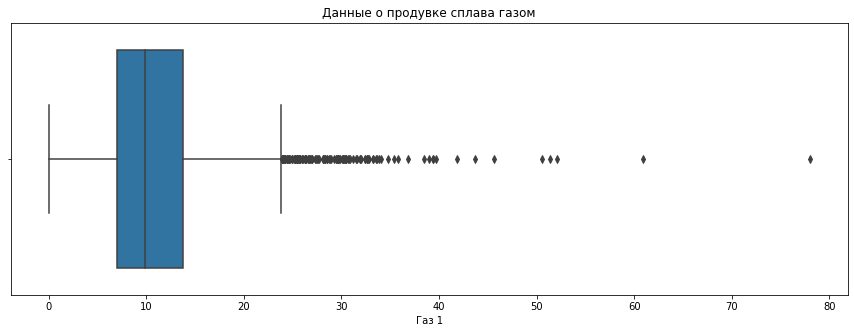

In [11]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_gas, x='Газ 1')
plt.title('Данные о продувке сплава газом')

plt.show();

**Результаты измерения температуры**

In [12]:
df_gas_temp = pd.read_csv('/datasets/data_temp_new.csv');df_gas_temp.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [13]:
df_gas_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


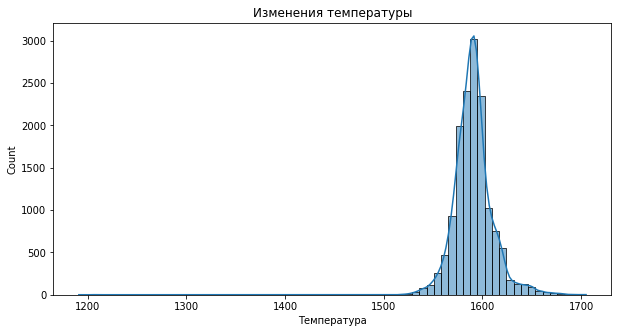

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_gas_temp, x='Температура', bins=70, kde=True)
plt.title('Изменения температуры')
plt.xlabel('Температура')
plt.show();

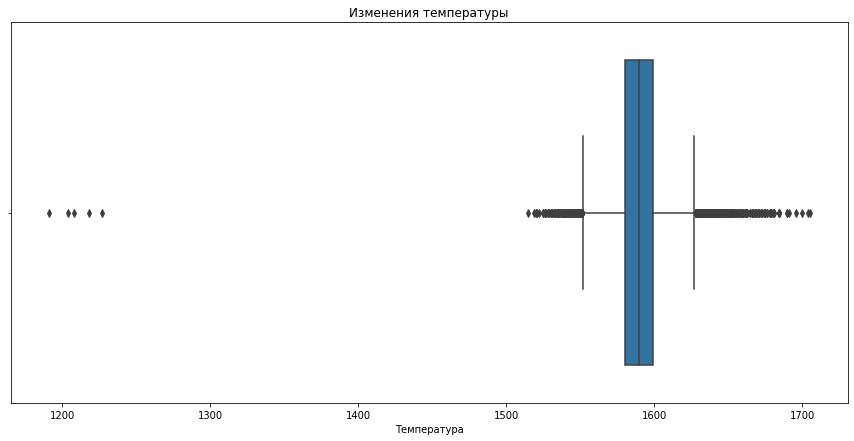

In [15]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df_gas_temp, x='Температура')
plt.title('Изменения температуры')
plt.xlabel('Температура')
plt.show();

**Промежуточный вывод:**

    1.Есть выбросы.
    

**Данные о проволочных материалах(объем)**

In [16]:
df_wire = pd.read_csv('/datasets/data_wire_new.csv');df_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


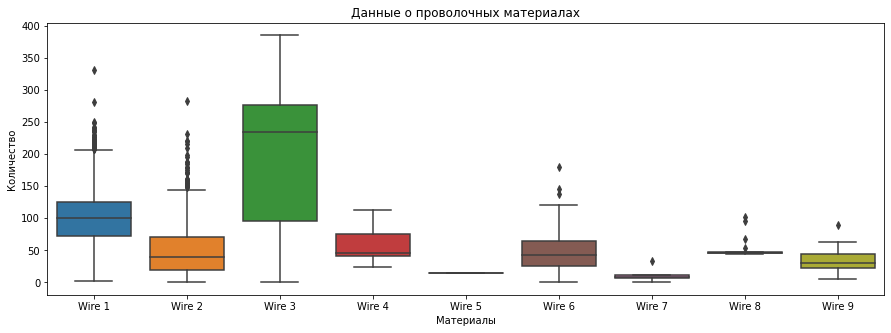

In [18]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_wire.drop('key', axis=1))
plt.title('Данные о проволочных материалах')
plt.xlabel('Материалы')
plt.ylabel('Количество')

plt.show();

**Промежуточный вывод:**

    1.Пропуски заменили на 0
    2.Наблюдаются выбросы

**Данные о проволочных материалах(время)**

In [19]:
df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv');
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


## Предобработка данных

In [21]:
df_gas.rename(columns={'Газ 1': 'Gas'}, inplace=True)
df_gas

,key,Gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [22]:
df_gas_temp = df_gas_temp.sort_values(by=['key', 'Время замера'])
df_gas_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 565.4+ KB


In [23]:
idx = [0]
for i in range(1, len(df_gas_temp)):
    prev_key = df_gas_temp.loc[i - 1].key
    next_key = df_gas_temp.loc[i].key
    if (prev_key != next_key):
        idx.append(i)
df_min_time_temp = df_gas_temp[['key', 'Температура']].loc[idx]
df_min_time_temp.rename(columns={'Температура': 'First_temp'}, inplace=True)
df_min_time_temp

,key,First_temp
0,1,1571.0
6,2,1581.0
11,3,1596.0
17,4,1601.0
22,5,1576.0
...,...,...
18061,3237,1569.0
18067,3238,1584.0
18071,3239,1598.0
18080,3240,1617.0


In [24]:
df_min_time_temp = df_min_time_temp[(df_min_time_temp.First_temp >= 1500) & (df_min_time_temp.First_temp.notnull())]
df_min_time_temp

,key,First_temp
0,1,1571.0
6,2,1581.0
11,3,1596.0
17,4,1601.0
22,5,1576.0
...,...,...
18061,3237,1569.0
18067,3238,1584.0
18071,3239,1598.0
18080,3240,1617.0


In [25]:
idx = []
for i in range(1, len(df_gas_temp)):
    prev_key = df_gas_temp.loc[i - 1].key
    next_key =  df_gas_temp.loc[i].key
    if (prev_key != next_key):
        idx.append(i - 1)
idx.append(len(df_gas_temp) - 1)
df_max_time_temp = df_gas_temp[['key', 'Температура']].loc[idx]
df_max_time_temp.rename(columns={'Температура': 'Last_temp'}, inplace=True)
df_max_time_temp

,key,Last_temp
5,1,1613.0
10,2,1602.0
16,3,1599.0
21,4,1625.0
26,5,1602.0
...,...,...
18066,3237,NaN
18070,3238,NaN
18079,3239,NaN
18085,3240,NaN


In [26]:
df_max_time_temp = df_max_time_temp[(df_max_time_temp.Last_temp >= 1500) & (df_max_time_temp.Last_temp.notnull())]
df_max_time_temp

,key,Last_temp
5,1,1613.0
10,2,1602.0
16,3,1599.0
21,4,1625.0
26,5,1602.0
...,...,...
13903,2495,1591.0
13910,2496,1591.0
13914,2497,1589.0
13920,2498,1594.0


In [27]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [28]:
df_arc[df_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [29]:
del_key = df_arc[df_arc['Реактивная мощность'] < 0]['key'].to_list()
df_arc = df_arc[~df_arc['key'].isin(del_key)]
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [30]:
df_arc['Time_diff'] = (pd.to_datetime(df_arc['Конец нагрева дугой']) - pd.to_datetime(df_arc['Начало нагрева дугой'])).dt.total_seconds()
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Time_diff
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157.0
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180.0
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184.0
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57.0


In [31]:
df_arc_mean = df_arc.groupby('key', as_index=False).mean().set_index('key')
df_arc_mean.rename(columns={'Активная мощность': 'Active_power', 'Реактивная мощность': 'Reactive_power'}, inplace=True)
df_arc_mean

,Active_power,Reactive_power,Time_diff
key,,,
1,0.607346,0.428564,219.60
2,0.534852,0.363339,202.75
3,0.812728,0.587491,131.00
4,0.676622,0.514248,185.25
5,0.563238,0.421998,217.25
...,...,...,...
3237,0.508374,0.405083,181.80
3238,0.458274,0.346034,182.00
3239,0.606001,0.442693,152.00


### Объединяем данные таблиц в одну общую с которой будем уже работать в модели

In [32]:
data = df_min_time_temp.merge(df_max_time_temp, on='key', how='inner')
data = data[data.First_temp != data.Last_temp]
data = data.merge(df_gas, on='key', how='inner')
data = data.merge(df_arc_mean, on='key', how='inner')
data = data.merge(df_wire, on='key', how='inner')
data = data.merge(df_bulk, on='key', how='inner')
data = data.set_index('key')
data

,First_temp,Last_temp,Gas,Active_power,Reactive_power,Time_diff,Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,29.749986,0.607346,0.428564,219.600000,60.059998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,1581.0,1602.0,12.555561,0.534852,0.363339,202.750000,96.052315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,1596.0,1599.0,28.554793,0.812728,0.587491,131.000000,91.160157,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,1601.0,1625.0,18.841219,0.676622,0.514248,185.250000,89.063515,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,1576.0,1602.0,5.413692,0.563238,0.421998,217.250000,89.238236,9.11456,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,7.125735,0.792033,0.552734,180.750000,89.150879,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,90.0,NaN,256.0,NaN,129.0,223.0
2496,1554.0,1591.0,9.412616,0.695820,0.478672,156.666667,114.179527,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,122.0,NaN,256.0,NaN,129.0,226.0
2497,1571.0,1589.0,6.271699,1.201746,0.817364,189.666667,94.086723,9.04800,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,230.0,NaN,124.0,226.0


In [33]:
data['Full_power'] = (data['Active_power']**2 + data['Reactive_power']**2)**0.5;data

,First_temp,Last_temp,Gas,Active_power,Reactive_power,Time_diff,Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Full_power
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,29.749986,0.607346,0.428564,219.600000,60.059998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,0.743328
2,1581.0,1602.0,12.555561,0.534852,0.363339,202.750000,96.052315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,0.646593
3,1596.0,1599.0,28.554793,0.812728,0.587491,131.000000,91.160157,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,1.002833
4,1601.0,1625.0,18.841219,0.676622,0.514248,185.250000,89.063515,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,0.849864
5,1576.0,1602.0,5.413692,0.563238,0.421998,217.250000,89.238236,9.11456,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,0.703789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,7.125735,0.792033,0.552734,180.750000,89.150879,NaN,NaN,NaN,...,NaN,NaN,NaN,90.0,NaN,256.0,NaN,129.0,223.0,0.965832
2496,1554.0,1591.0,9.412616,0.695820,0.478672,156.666667,114.179527,NaN,NaN,NaN,...,NaN,NaN,NaN,122.0,NaN,256.0,NaN,129.0,226.0,0.844566
2497,1571.0,1589.0,6.271699,1.201746,0.817364,189.666667,94.086723,9.04800,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,230.0,NaN,124.0,226.0,1.453368


In [34]:
data = data.fillna(0); data.isna().sum()

First_temp        0
Last_temp         0
Gas               0
Active_power      0
Reactive_power    0
Time_diff         0
Wire 1            0
Wire 2            0
Wire 3            0
Wire 4            0
Wire 5            0
Wire 6            0
Wire 7            0
Wire 8            0
Wire 9            0
Bulk 1            0
Bulk 2            0
Bulk 3            0
Bulk 4            0
Bulk 5            0
Bulk 6            0
Bulk 7            0
Bulk 8            0
Bulk 9            0
Bulk 10           0
Bulk 11           0
Bulk 12           0
Bulk 13           0
Bulk 14           0
Bulk 15           0
Full_power        0
dtype: int64

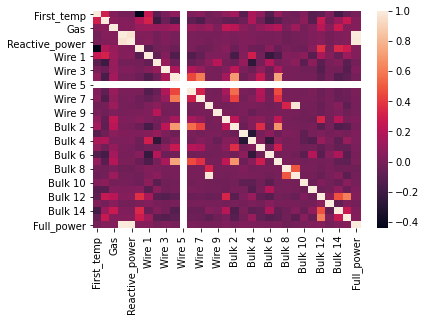

In [35]:
sns.heatmap(data.corr());

**Промежуточный вывод:** после предобработки данных, видно на матрице корреляции что столбец Wire 5 не несет в себе ни какой смысловой нагрузки, поэтому его убираем из выборки

### Разбиение на выборки

In [36]:
features = data.drop(['Wire 5', 'Last_temp'], axis=1)
target = data['Last_temp']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=30723)

features_train = features_train[features_train['Gas'] < 21]
target_train = target_train.loc[features_train.index]

print('Размер тренировочных данных:', features_train.shape)
print('Размер тестовых данных:', features_test.shape)
print('Размер целевого тренировочного:', target_train.shape)
print('Размер целевого тестового:', target_test.shape)

Размер тренировочных данных: (1598, 29)
Размер тестовых данных: (572, 29)
Размер целевого тренировочного: (1598,)
Размер целевого тестового: (572,)


### Train model

**DecisionTreeRegressor**

In [37]:
%%time

RANDOM_STATE = 30723
SPLIT_COUNT = 4

k_fold = StratifiedKFold(n_splits=SPLIT_COUNT, shuffle=True, random_state=RANDOM_STATE)

def fit_model_with_best_params(name: str, estimator: BaseEstimator, param_grid: dict) -> dict:
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=k_fold, verbose=3, scoring='neg_mean_absolute_error')
    grid_search.fit(features_train, target_train)

    estimator.set_params(**grid_search.best_params_)
    estimator.fit(features_train, target_train)

    predicted_values = estimator.predict(features_train)
    mae = mean_absolute_error(target_train, predicted_values)

    return {
        'Name': name,
        'Model': estimator,
        'BestParams': grid_search.best_params_,
        'BestScore': -grid_search.best_score_,
        'MAE': mae
    }


CPU times: user 33 µs, sys: 2 µs, total: 35 µs
Wall time: 37.2 µs


In [38]:
def show_feature_importance(estimator: BaseEstimator):
    importance = estimator.feature_importances_
    plt.figure(figsize=(12, 12))
    plt.barh(features_train.columns, importance)
    plt.xticks(rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Feature Importance")
    plt.show()

In [39]:
decision_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

decision_tree_param_grid = {
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 3, 5],
}

decision_tree_result = fit_model_with_best_params('decision_tree', decision_tree, decision_tree_param_grid)
decision_tree_result

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV 1/4] END max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV 2/4] END max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV 3/4] END max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV 4/4] END max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV 1/4] END max_depth=4, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV 2/4] END max_depth=4, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV 3/4] END max_depth=4, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV 4/4] END max_depth=4, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV 1/4] END max_depth=4, min_samples_leaf=1, min_samples_split=6; total time=   0.0s
[CV 2/4] END max_depth=4, min_samples_leaf=1, min_samples_split=6; total time=   0.0s
[CV 3/4] END max_depth=4, min_samples_leaf=1, min_samples_split=6; total time=

{'Name': 'decision_tree',
 'Model': DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=30723),
 'BestParams': {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2},
 'BestScore': 7.542938971898014,
 'MAE': 6.821322386864133}

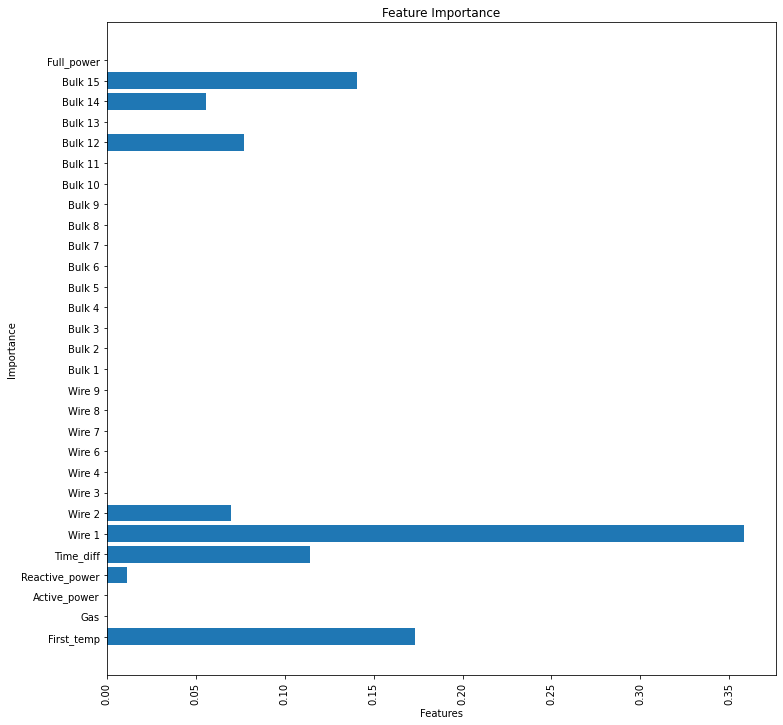

In [40]:
show_feature_importance(estimator = decision_tree_result['Model'])

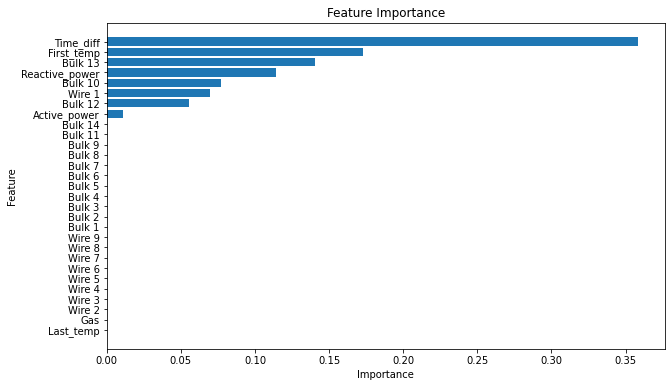

In [41]:
feature_importances = decision_tree.feature_importances_

def plot_feature_importance(sorted_features):
    features, importances = zip(*sorted_features)

    sorted_indices = sorted(range(len(importances)), key=lambda k: importances[k], reverse=False)
    features = [features[i] for i in sorted_indices]
    importances = [importances[i] for i in sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(features)), importances, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

sorted_features = sorted(zip(data.columns, feature_importances), key=lambda x: x[1], reverse=True)
plot_feature_importance(sorted_features)

**CatBoostRegressor**

In [42]:
cat_boost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

cat_boost_params = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7]
}
cat_boost_result = fit_model_with_best_params('cat_boost', cat_boost, cat_boost_params)
cat_boost_result

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV 1/4] END ..depth=3, learning_rate=0.01, n_estimators=200; total time=   0.7s
[CV 2/4] END ..depth=3, learning_rate=0.01, n_estimators=200; total time=   0.6s
[CV 3/4] END ..depth=3, learning_rate=0.01, n_estimators=200; total time=   0.7s
[CV 4/4] END ..depth=3, learning_rate=0.01, n_estimators=200; total time=   0.6s
[CV 1/4] END ..depth=3, learning_rate=0.01, n_estimators=300; total time=   0.8s
[CV 2/4] END ..depth=3, learning_rate=0.01, n_estimators=300; total time=   0.8s
[CV 3/4] END ..depth=3, learning_rate=0.01, n_estimators=300; total time=   0.8s
[CV 4/4] END ..depth=3, learning_rate=0.01, n_estimators=300; total time=   0.8s
[CV 1/4] END ..depth=3, learning_rate=0.01, n_estimators=400; total time=   1.0s
[CV 2/4] END ..depth=3, learning_rate=0.01, n_estimators=400; total time=   0.9s
[CV 3/4] END ..depth=3, learning_rate=0.01, n_estimators=400; total time=   1.0s
[CV 4/4] END ..depth=3, learning_rate=0.01, n_e

{'Name': 'cat_boost',
 'Model': <catboost.core.CatBoostRegressor at 0x7fe1ef11c6d0>,
 'BestParams': {'depth': 7, 'learning_rate': 0.05, 'n_estimators': 200},
 'BestScore': 6.580919476970126,
 'MAE': 5.078089381590272}

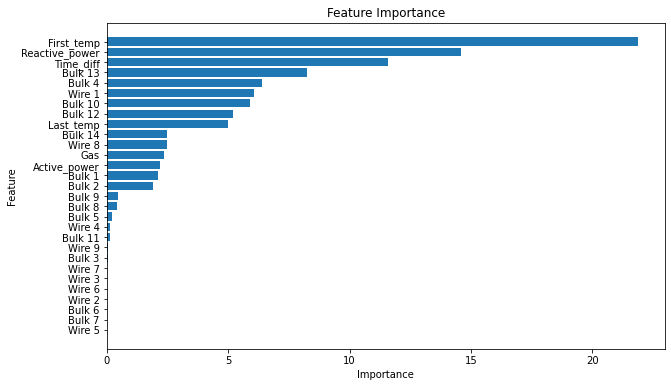

In [43]:
feature_importances = cat_boost.feature_importances_

def plot_feature_importance(sorted_features):
    features, importances = zip(*sorted_features)

    sorted_indices = sorted(range(len(importances)), key=lambda k: importances[k], reverse=False)
    features = [features[i] for i in sorted_indices]
    importances = [importances[i] for i in sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(features)), importances, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

sorted_features = sorted(zip(data.columns, feature_importances), key=lambda x: x[1], reverse=True)
plot_feature_importance(sorted_features)

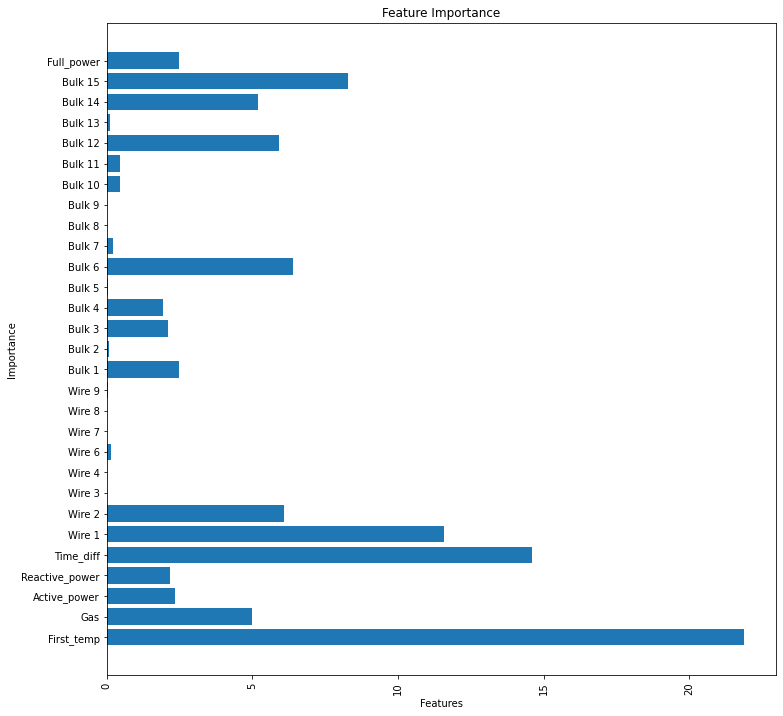

In [44]:
show_feature_importance(estimator = cat_boost_result['Model'])

In [45]:
model_result = pd.DataFrame([
    decision_tree_result,
    cat_boost_result]
)
model_result.sort_values(by='BestScore', ascending=False).head(10)

,Name,Model,BestParams,BestScore,MAE
0,decision_tree,"DecisionTreeRegressor(max_depth=4, min_samples...","{'max_depth': 4, 'min_samples_leaf': 5, 'min_s...",7.542939,6.821322
1,cat_boost,<catboost.core.CatBoostRegressor object at 0x7...,"{'depth': 7, 'learning_rate': 0.05, 'n_estimat...",6.580919,5.078089


**Промежуточный вывод:** по результату на тренировочных данных принимаем решение для дальнейшей работы взять модель CatBoost с гиперпараметрами: 'depth': 7, 'learning_rate': 0.05, 'n_estimators': 200

### Test model

In [46]:
def fit_model_with_best_params(name: str, estimator: BaseEstimator, params: dict) -> dict:
    estimator.set_params(**params)
    estimator.fit(features_train, target_train)

    predicted_values = estimator.predict(features_test)
    mae = mean_absolute_error(target_test, predicted_values)

    return {
        'Name': name,
        'Model': estimator,
        'Params': params,
        'MAE': mae
    }

cat_boost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

cat_boost_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'depth': 7
}

cat_boost_result = fit_model_with_best_params('cat_boost', cat_boost, cat_boost_params)
cat_boost_result


{'Name': 'cat_boost',
 'Model': <catboost.core.CatBoostRegressor at 0x7fe1ee7853d0>,
 'Params': {'n_estimators': 200, 'learning_rate': 0.05, 'depth': 7},
 'MAE': 6.733532796316115}

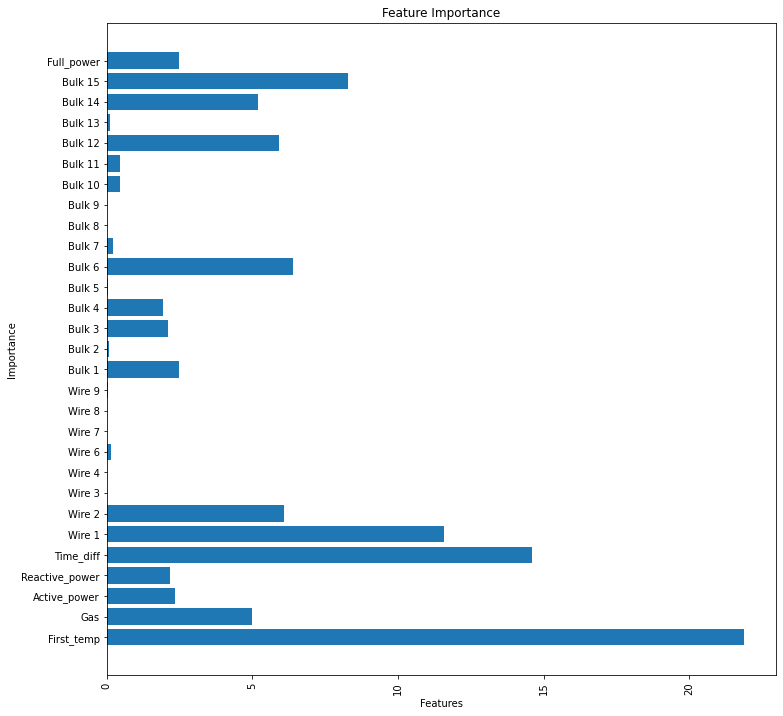

In [47]:
show_feature_importance(estimator = cat_boost_result['Model'])

In [48]:
model_result = pd.DataFrame([
    cat_boost_result]
)
model_result.sort_values(by='Name', ascending=False).head(10)

,Name,Model,Params,MAE
0,cat_boost,<catboost.core.CatBoostRegressor object at 0x7...,"{'n_estimators': 200, 'learning_rate': 0.05, '...",6.733533


**Вывод:** как оказалось в данных было очень много пропусков и на большое количество аномалий. Пропуски заменили на 0, аномалии удалили. Сделали преобработку данных собрав в группы все ковши и получив по одному замеру в каждом, добавили пару фич. Прогнали данные через дерево решений и catboost. Ожидаемо буст показал результат лучше.

## Отчет по проделанной работе

    В процессе выполнения проекта был уточнен и дополнен исходный план, разработанный после проведения разведывательного анализа данных. Несмотря на это, общая структура плана осталась неизменной, и все его пункты были успешно выполнены.
    В ходе разведывательного анализа данных мы обратили внимание на высокую долю повторяющихся данных в различных датасетах. Оказалось, что некоторые наборы данных не имели прямого отношения к поставленной задаче. После тщательного анализа мы решили исключить данные о времени добавления присадок.
    Во время предобработки данных возникла соблазнительная возможность удалить выбросы в некоторых признаках. Однако, учитывая, что у нас отсутствовала подробная информация о технологическом процессе, мы приняли решение не удалять выбросы, поскольку это могло бы быть некорректным.
    Основные этапы проекта включали:
        1.Анализ полученных данных.
        2.Обнаружение и удаление явных выбросов.
        3.Создание новых признаков на основе имеющихся данных.
        4.Формирование окончательного датасета.
        5.Проверка признаков на наличие мультиколлинеарности.
        6.Использование нескольких моделей и выбор наилучшей из них.
        7.Оценка важности признаков для прогнозирования конечной температуры.
        8.Сравнение результатов моделей с константной моделью.
        9.Тестирование наилучшей модели на отложенной выборке.
    Итоговая модель, основанная на стохастическом градиентном бустинге (SGB) с использованием CatBoost, была выбрана для предсказания конечной температуры. Модель была обучена с помощью функции потерь MAE (mean_absolute_error) и шага градиентного бустинга 0,05. Средняя абсолютная ошибка (MAE) составила около 5°C на тренировочной выборке и около 6.7°C на тестовой выборке.
    В итоговый датасет вошли следующие признаки:
        Из датасета 'data arc new.csv' была удалена партия с аномальным значением по реактивной мощности, и был создан новый признак 'full power'.
        В датасетах 'data bulk new.csv' и 'data wire new.csv' пропущенные значения были заменены на нулевые.
        Из датасета 'data gas new.csv' были включены все имеющиеся данные.
        Из датасета 'data temo new.csv' были удалены партии с температурой ниже 1400°C и партии с только одним замером температуры.